I had a lot of trouble here when working with individual structures.

When using nearest interpolation the gradient is 0.

I had to pull the target back, then update the atlas image with contrast transform.

This process is working, but there is VERY little out of plane motion.

In version 4 I will work with expression data


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time
from scipy.stats import norm

In [2]:
dtype = torch.float32
device = 'cpu'
#device = 'cuda:1'

In [3]:
# note there are two types of files, one is metadata, and one is by_gene

In [4]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*by_gene*.csv.gz')
files.sort()

In [5]:
# lets read the cell expression, that's all for
df = pd.read_csv(files[0])
df

,Unnamed: 0,Oxgr1,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr4,...,Blank-156,Blank-157,Blank-158,Blank-159,Blank-160,Blank-161,Blank-162,Blank-163,Blank-164,Blank-165
0,110883424764611924400221639916314253469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,135188247894899244046039873973964001182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,164766962839370328502017156371562646881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,165747897693809971960756442245389760838,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260943245639750847364278545493286724628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78324,165273009496786595275688065919008183969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78325,250474226357477911702383283537224741401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78326,66106840181174834341279408890707577820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78327,66165211106933093510165165316573672348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
F = np.array(df.iloc[:,1:])

In [7]:
npca = 3
muF = np.mean(F,0,keepdims=True)
F0 = F - muF
S = (F0.T@F0)/F0.shape[0] # covariance
w,v = np.linalg.eigh(S)
tform = F0@v
f = tform[:,-npca:]

<IPython.core.display.Javascript object>


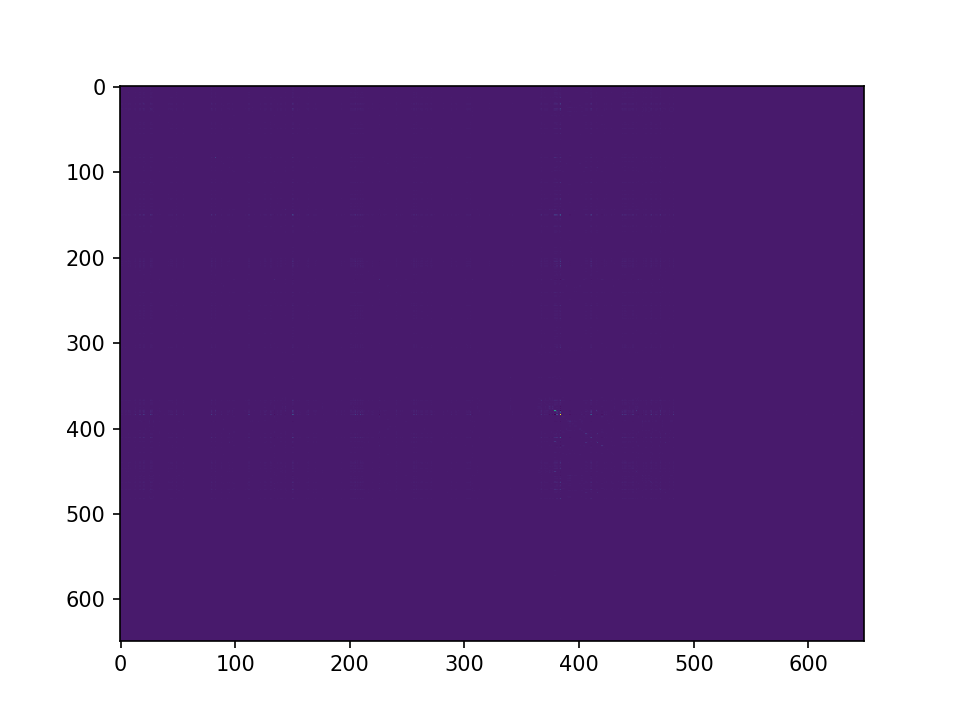

In [8]:
f,ax = plt.subplots()
ax.imshow(S,aspect='auto')

In [9]:
files = [files[0]]

In [10]:
# now we will use torch
import torch
from torch.nn.functional import grid_sample
# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(3):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,3,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [11]:
# timesteps will be along the first axis
def v_to_phii(xv,v):
    '''
    Inputs: 
        xv -> list of 1D tensors describing locations of sample points
        v -> 5D (nt,3,v0,v1,v2) velocity field
    Output:
        phii (inverse map) computed by method of characteristics

    '''
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

In [12]:
def to_A(L,T):
    O = torch.tensor([0.,0.,0.,1.],device=L.device,dtype=L.dtype)
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

<IPython.core.display.Javascript object>


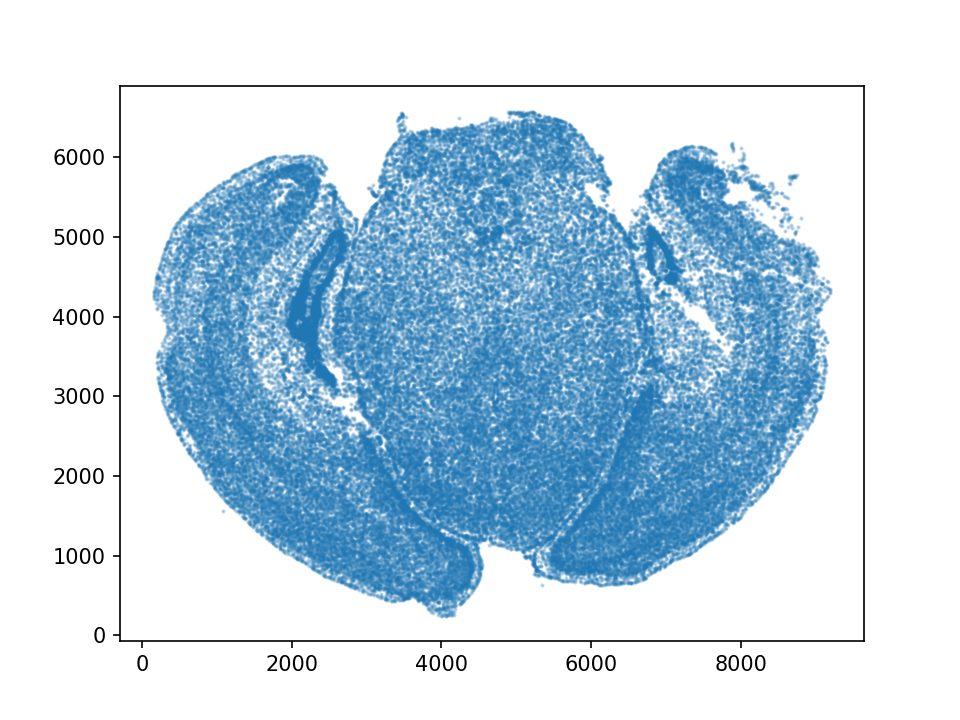

(140, 199)


<IPython.core.display.Javascript object>


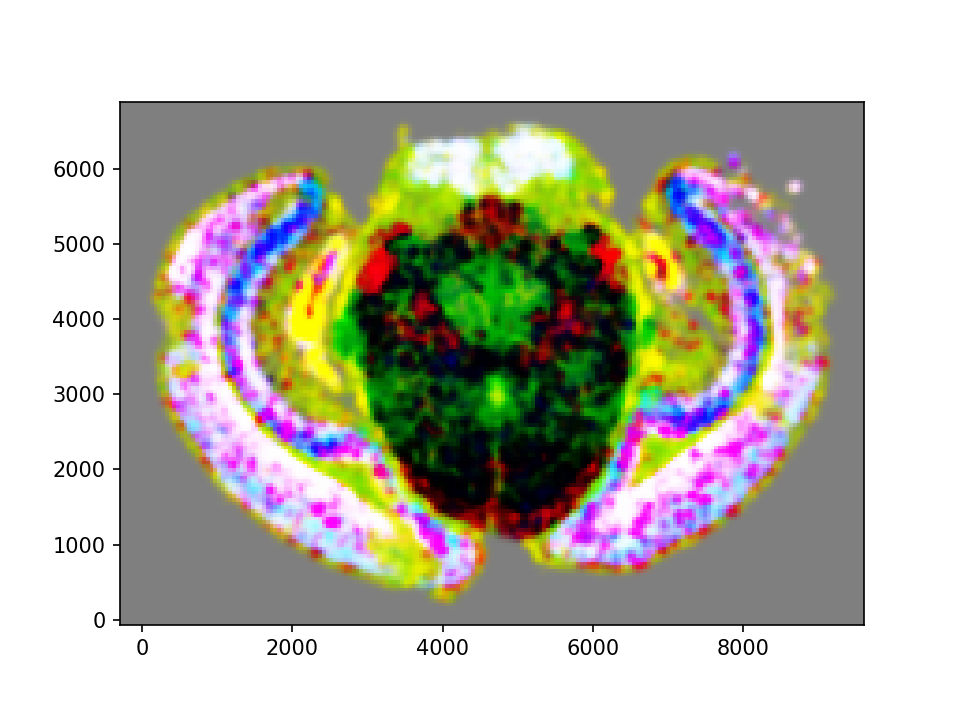

0 of 78329
10000 of 78329
20000 of 78329
30000 of 78329
40000 of 78329
50000 of 78329
60000 of 78329
70000 of 78329
78328 of 78329
350 -0.17453292519943295


<IPython.core.display.Javascript object>


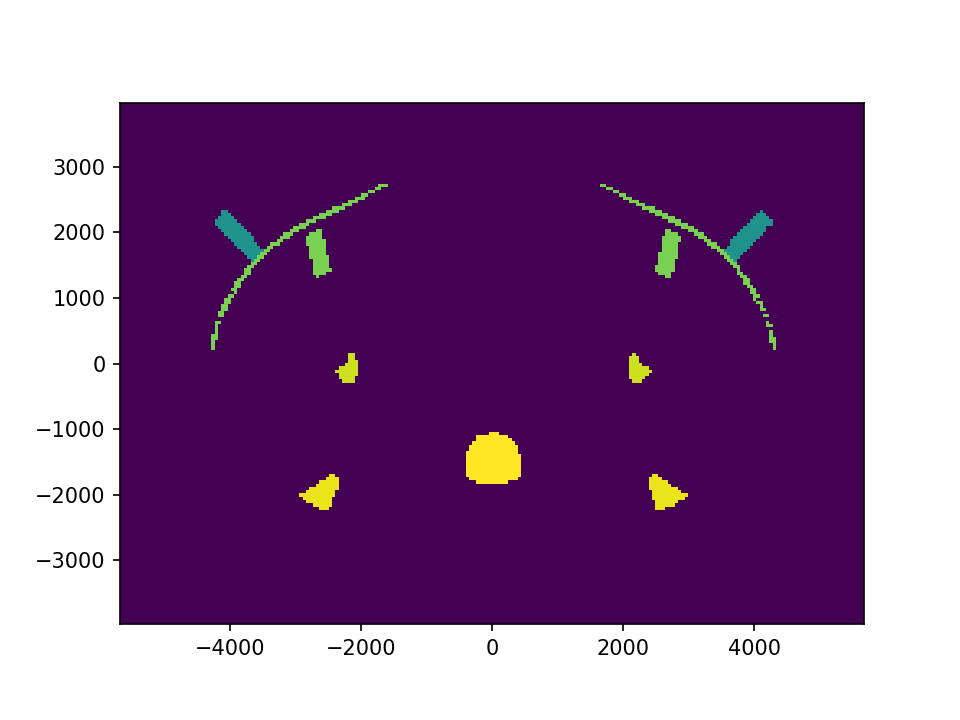

<IPython.core.display.Javascript object>


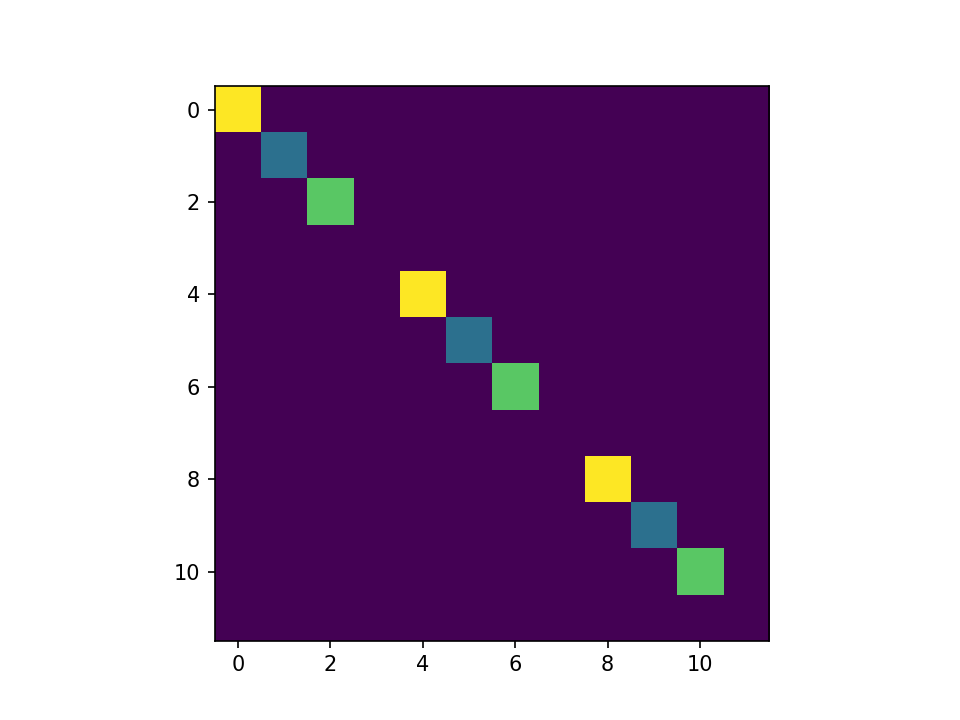

<IPython.core.display.Javascript object>


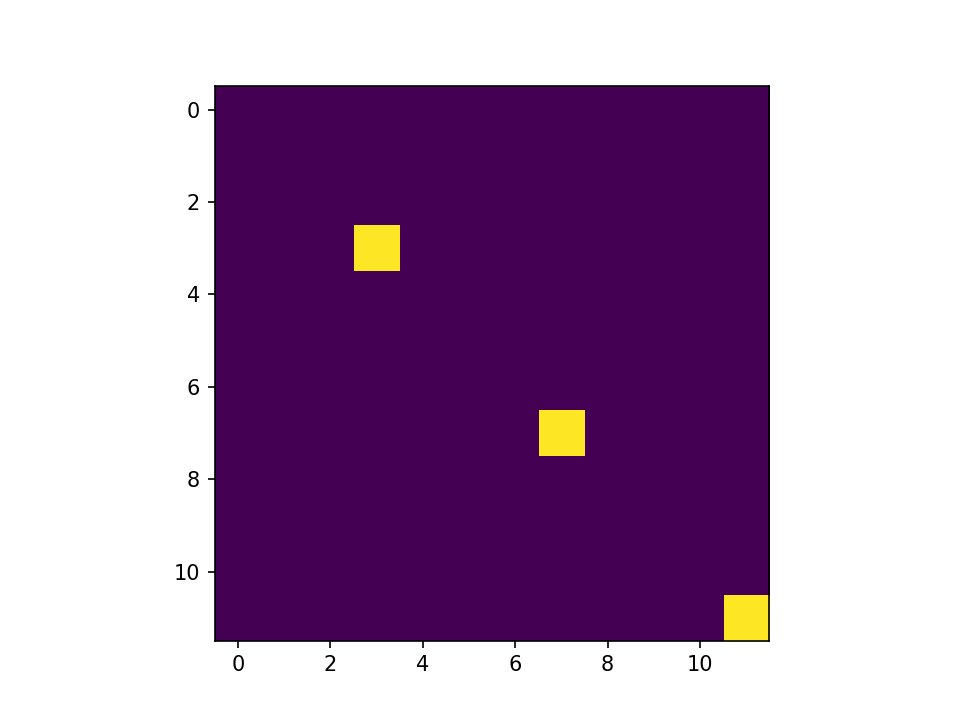

tensor([[ 1.0000,  0.0200,  0.0200],
        [-0.0200,  0.9848,  0.1736],
        [-0.0200, -0.1736,  0.9848]], requires_grad=True) tensor([-2175.,  4000.,  5000.], requires_grad=True)
tensor([[ 1.0000,  0.0200,  0.0200],
        [-0.0200,  0.9848,  0.1736],
        [-0.0200, -0.1736,  0.9848]], requires_grad=True) tensor([-2175.,  4000.,  5000.], requires_grad=True)


<IPython.core.display.Javascript object>


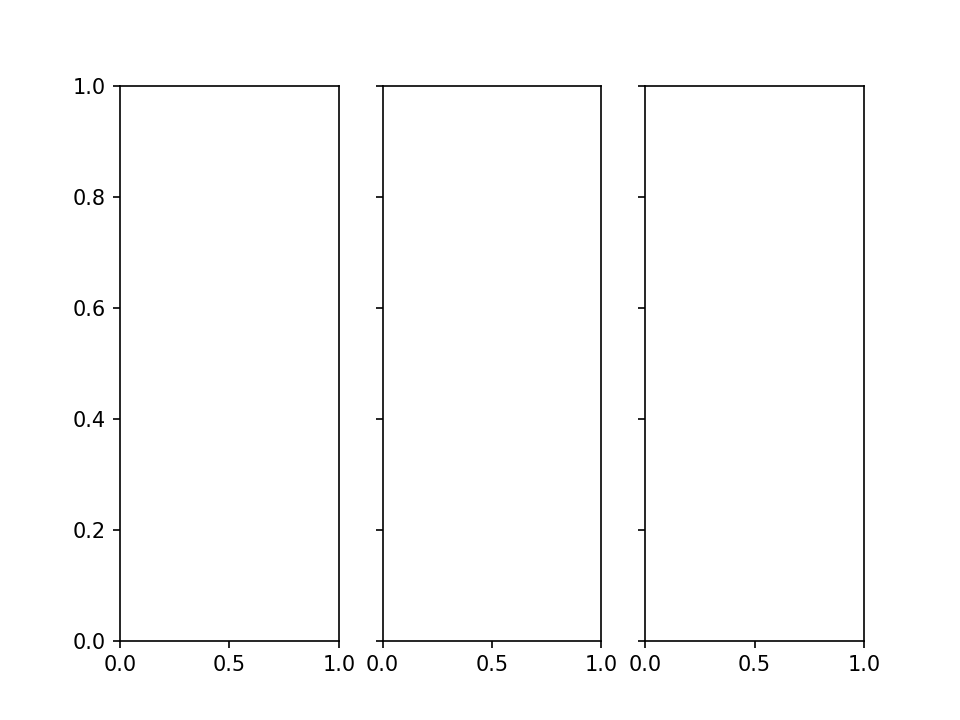

<IPython.core.display.Javascript object>


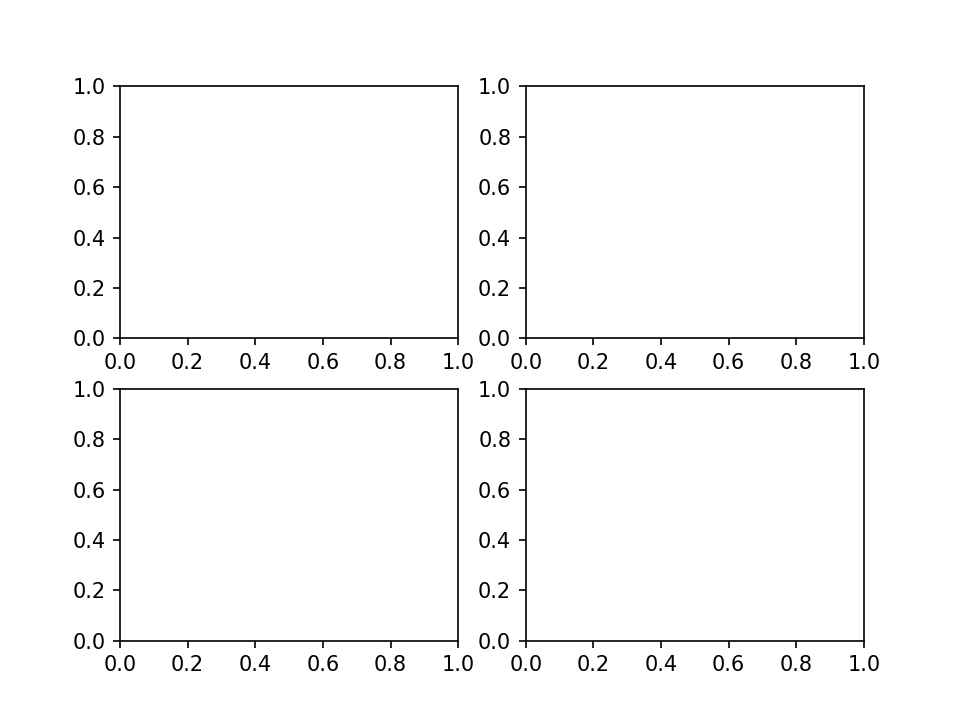

IndexError: The shape of the mask [1, 1, 140, 199] at index 0 does not match the shape of the indexed tensor [3, 1, 140, 199] at index 0

In [13]:
for fname in files:
    #if 'structure_id' in fname: continue
    #fname = '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv.gz'



    names = os.path.splitext(fname)
    if names[1] == '.gz':
        names = os.path.splitext(names[0])
    outname = names[0] + '_with_structure_id_v02.csv'
    
    
    df = pd.read_csv(fname.replace('by_gene','metadata'))
    x = np.array(df['center_x'])
    y = np.array(df['center_y'])
    v = np.array(df['volume'])
    
    
    df_ = pd.read_csv(fname.replace('metadata','by_gene'))
    F = np.array(df_.iloc[:,1:])
    npca = 3
    muF = np.mean(F,0,keepdims=True)
    F0 = F - muF
    S = (F0.T@F0)/F0.shape[0] # covariance
    w,v = np.linalg.eigh(S)
    tform = (F0@v) @ np.diag(1.0/np.sqrt(w))
    f = tform[:,-npca:]

    N = x.shape[0]
    mat = np.array([[9.20788192749023E+00, 0E+00, -3.77225189208984E+02],
                [0E+00, 9.20783615112305E+00, 9.39383850097656E+02],
                [0E+00, 0E+00, 1E+00 ]])
    mat = np.eye(3)
    xy = np.stack((x,y),0)
    xy = mat[:2,:2]@xy + mat[:2,-1][:,None]
    x,y = xy
    fig,ax = plt.subplots()
    ax.scatter(x,y,s=1,alpha=0.25)
    #ax.invert_yaxis()
    # what are the units in xy
    # they should be microns
    # they're probably pixel, the conversion factor is
    fig.canvas.draw()
    
    
    # now we want to rasterize
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    expand = 1.1
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand

    dx = 50 # I will register to 50 micron atlas
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    X = np.stack(np.meshgrid(X_,Y_))
    blur = 0.75 # gaussian std in voxels
    blur = 1.0
    W = np.zeros((len(Y_),len(X_)))
    I = np.zeros((npca,len(Y_),len(X_)))
    print(W.shape)
    
    
    fig,ax = plt.subplots()
    count = 0
    for x_,y_,f_ in zip(x,y,f):
        # to speed things up I shoul index
        # to do this I'd have to find row and column indices
        col = np.round((x_ - X_[0])/dx).astype(int)
        row = np.round((y_ - X_[1])/dx).astype(int)
        row0 = np.floor(row-blur*3).astype(int)
        row1 = np.ceil(row+blur*3).astype(int)
        rows = np.arange(row0,row1+1)
        #rows = np.arange(row,row+blur*3+1)
        #rows_ = np.arange(row,row-blur*3-1,-1)
        #rows__ = np.concatenate((rows_[::-1],rows[1:])).astype(int)
        #cols = np.arange(col,col+blur*3+1)
        #cols_ = np.arange(col,col-blur*3-1,-1)
        #cols__ = np.concatenate((cols_[::-1],cols[1:])).astype(int)

        ## this step is incrementing one pixel at a time, it is way way faster
        #I[c_,row,col] += 1.0
        #W[row,col] += 1.0

        k = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur)**2)  )
        k /= np.sum(k)
        #I[c_] += k 
        W += k
        I += k * f_[...,None,None]

        if not count%10000 or count==(x.shape[0]-1):
            print(f'{count} of {x.shape[0]}')

            ax.cla()
            #ax.imshow(W)
            ax.imshow(norm.cdf(I[:3].transpose(1,2,0)))
            fig.canvas.draw()

        count += 1
        
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    ax.cla()
    #ax.imshow(W,  origin='lower',extent=extent)
    ax.imshow(norm.cdf(I[:3].transpose(1,2,0)),  origin='lower',extent=extent)
    fig.canvas.draw()
    fig.savefig(outname[:-4]+'_image.png')
    
    # start by loading the atlas
    
    imagefile = '/home/dtward/data/AllenInstitute/ara_nissl/ara_nissl_50.nrrd'
    imagefile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    vol,hdr = nrrd.read(imagefile)
    A = vol
    #A = rankdata(A).reshape(A.shape) # this isn't exactly what I want
    #fig,ax = plt.subplots()
    #ax.imshow(A[50])

    labelfile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    vol,hdr = nrrd.read(labelfile)
    L = vol
    #fig,ax = plt.subplots()
    #ax.imshow(L[50]%7)

    dxA = np.diag(hdr['space directions'])
    nxA = A.shape
    xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
    XA = np.meshgrid(*xA,indexing='ij')
    
    # we need to get a slice for each
    theta0 = 0.0
    if 'S1R1' in fname:
        slice_ = 350
        theta0 = -10.0*np.pi/180 # negative rotates counter clockwise
    elif 'S1R2' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S1R3' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S2R1' in fname:
        slice_ = 270
        theta0 = -10.0*np.pi/180
    elif 'S2R2' in fname:
        slice_ = 270
        theta0 = -(90+45)*np.pi/180
    elif 'S2R3' in fname:
        slice_ = 270
        theta0 = 180*np.pi/180
    elif 'S3R1' in fname:
        slice_ = 180
        theta0 = 45*np.pi/180
    elif 'S3R2' in fname:
        slice_ = 180
        theta0 = 0.0
    elif 'S3R3' in fname:
        slice_ = 180
        theta0 = -(90+45)*np.pi/180
    print(slice_,theta0)
        
    fig,ax = plt.subplots()
    ax.imshow(A[slice_//2],extent=[xA[2][0],xA[2][-1],xA[1][0],xA[1][-1]])
    
    
    


    J = torch.as_tensor(I[:,None,:,:],dtype=dtype,device=device)
    #I = torch.as_tensor(A[None]/np.mean(np.abs(A)),dtype=dtype,device=device)
    I = torch.as_tensor(A[None].astype(np.int64),dtype=dtype,device=device) # for label
    
    xI = [torch.as_tensor(x,dtype=dtype,device=device) for x in xA]
    xJ = [torch.as_tensor([0.0],device=device,dtype=dtype),
          torch.as_tensor(Y_,device=device,dtype=dtype),
          torch.as_tensor(X_,device=device,dtype=dtype)]
    XJ = torch.stack(torch.meshgrid(xJ),-1)
    XI = torch.stack(torch.meshgrid(xI),-1)
    
    # velocity
    dI = torch.tensor([x[1]-x[0] for x in xI],device=device,dtype=dtype)
    #xv = [x[::2] for x in xI]
    #dv = torch.tensor([x[1]-x[0] for x in xv])
    dv = dI*3
    buf = 20
    xv = [torch.arange(x[0]-dIi*buf,x[-1]+dIi*buf,dvi,device=device,dtype=dtype) for x,dIi,dvi in zip(xI,dI,dv)]
    a = dv[0]*3.0
    p = 2.0
    nv = torch.tensor([len(x) for x in xv],device=device,dtype=int)
    XV = torch.stack(torch.meshgrid(xv),-1)
    fv = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nv,dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 - 2.0*a**2 * 
                  ( (torch.cos(2.0*np.pi*FV[...,0]*dv[0]) - 1)/dv[0]**2  
                + (torch.cos(2.0*np.pi*FV[...,1]*dv[1]) - 1)/dv[1]**2  
                + (torch.cos(2.0*np.pi*FV[...,2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
    K = 1.0/LL
    
    
    
    
    
    # metric
    # we'll use the pullback on the points in the atlas
    
    if 'g' not in globals(): # only need to do this once
        g = torch.zeros((12,12),device=device,dtype=dtype)
        count = 0
        for i in range(12):
            Ei = (torch.arange(16,device=device,dtype=int)==i).reshape((4,4))*1.0
            EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
            for j in range(12):
                Ej = (torch.arange(16,device=device,dtype=int)==j).reshape((4,4))*1.0
                EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
                g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))


            
    gi = torch.inverse(g)
    fig,ax = plt.subplots()
    ax.imshow(g.cpu().numpy())
    #ax.imshow(torch.log(torch.abs(g))*torch.sign(g))
    fig.canvas.draw()

    fig,ax = plt.subplots()
    ax.imshow(gi.cpu().numpy())
    #ax.imshow(torch.log(torch.abs(g))*torch.sign(g))
    fig.canvas.draw()

    
    # affine matrix 
    L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)
    #L.data[1,1] = -1
    L.data[1,1] = np.cos(theta0)
    L.data[2,1] = np.sin(theta0)
    L.data[1,2] = -np.sin(theta0)
    L.data[2,2] = np.cos(theta0)
    L.data[0,1] = 0.02
    L.data[0,2] = 0.02
    L.data[1,0] = -0.02
    L.data[2,0] = -0.02
    T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
    T.data[0] = -xI[0][slice_//2]
    T.data[1] = 4000
    T.data[2] = 5000
    print(L,T)
    #T.data[2] = 6000 # less good but double checking T
    #L.data = torch.tensor([[ 0.9997, -0.0089, -0.0033],
    #        [ 0.0017, -0.8628, -0.2064],
    #        [-0.0044, -0.2312,  0.8307]])
    #T.data = torch.tensor([ -166.5568, -3948.2505,  4890.3770])
    print(L,T)

    
    nt = 2
    v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True,device=device,dtype=dtype)
    
    
    f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
    f1,ax1 = plt.subplots(2,2)
    ax1 = ax1.ravel()

    # optimization
    niter = 1000
    eL = 1e-2
    eT = 1e5
    eA = 2e5
    ev = 1e9
    
    start3d = 250
    startdiff = 400
    
    eA = 1e5
    ev = 5e8
    start3d = 500
    startdiff = 800
    niter = 3000
    niter = 1
    
    sigmaR = 1e9

    Esave = []
    ERsave = []
    Tsave = []
    Lsave = []
    for it in range(niter):
        # generate
        phii = v_to_phii(xv,v.permute(0,4,1,2,3))
        # apply affine transform to atlas
        A = to_A(L,T)
        # invert
        Ai = torch.inverse(A)
        # sample points
        Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

        # compose
        Xs = (interp(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)

        # transform atlas
        AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest')# note mode=nearest for labels
        
        ## contrast
        #AI0 = AI - torch.mean(AI)
        #if it == 0:
        #    Jbar = torch.mean(J)
        #    J0 = J - Jbar
        #fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
        
        # we will want to update the contrast based on individual labels
        fAI = torch.clone(AI)
        for l in torch.unique(AI):
            ind = AI==l
            fAI[ind] = torch.mean(J[ind])

        # we will want to update the contrast based on individual labels
        #raise Exception('contrast')
        
        # cost
        err = fAI-J
        E = torch.mean(err**2)
        #vhat = torch.rfft(v.permute(0,4,1,2,3),3,onesided=False)
        vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))
        #ER = torch.sum(torch.sum(vhat**2,(0,1,-1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
        ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
        E = E + ER
        E.backward()

        Esave.append(E.item())
        ERsave.append(ER.item())
        Lsave.append(L.detach().clone().cpu().numpy().ravel())
        Tsave.append(T.detach().clone().cpu().numpy().ravel())

        # draw
        if not it%10:
            ax0[0].cla()
            ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower')
            ax0[1].cla()
            ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
            ax0[2].cla()
            ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')

            ax1[0].cla()
            ax1[0].plot(Esave)
            ax1[0].plot(ERsave)
            ax1[1].cla()
            ax1[1].plot(ERsave)
            ax1[2].cla()
            ax1[2].plot(Lsave)
            ax1[3].cla()
            ax1[3].plot(Tsave)

            # it would be good to draw the transform
            levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')

            f0.canvas.draw()
            f1.canvas.draw()
            
        # update
        with torch.no_grad():
            # combine grads
            grad = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
            grad = (gi@grad).reshape(3,4)

            if it > start3d:
                if it == start3d+1:
                    #eL /= 5
                    #eT /= 5
                    eA /= 5
                #L -= L.grad*eL
                #T -= T.grad*eT
                L -= grad[:3,:3]*eA
                T -= grad[:3,-1]*eA


            else:            
                #L[1:] -= L.grad[1:]*eL
                #T[1:] -= T.grad[1:]*eT
                L[1:] -= grad[:3,:3][1:]*eA
                T[1:] -= grad[:3,-1][1:]*eA
            L.grad.zero_()
            T.grad.zero_()

            if it > startdiff:
                #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
                vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1)
                v -= vgrad*ev
            v.grad.zero_()
            # TODO
            # use metric?
            # identifiability issues?
            
    f0.savefig(outname[:-4]+'_maps.png')
    f1.savefig(outname[:-4]+'_cost.png')
    
    
    # map the annotations
    vol,hdr = nrrd.read(labelfile)
    S = torch.as_tensor(vol.astype(float)[None],dtype=dtype,device=device) # note we need float for interp
    AS = torch.round(interp(xI,S,Xs.permute(3,0,1,2),mode='nearest')).int()

    fig,ax = plt.subplots()
    ax.imshow((AS[0,0]%7).detach().cpu().numpy(),
              origin='lower',extent=extent)
    ax.set_title('Labels')
    fig.canvas.draw()
    fig.savefig(outname[:-4]+'_labels.png')
    samples = torch.stack([torch.zeros(len(x),device=device,dtype=dtype),
                           torch.as_tensor(y,device=device,dtype=dtype),
                           torch.as_tensor(x,device=device,dtype=dtype)],-1)
    
    # assign cells to each label
    # I will have to use interpolation
    out = interp(xJ,AS.float(),samples[None,None].permute((3,0,1,2)),mode='nearest').int()
    # doesnt seem to be working, everything is zeros
    # I could also tansform the points and sample directly in atlas space

    
    # here is an update
    col = ((x - X_[0])/dx).astype(int)
    row = ((y - Y_[0])/dx).astype(int)
    out = AS[0,0,row,col]
    
    
    
    # get ready for writing
    df['structure_id'] = out.cpu().numpy()
    df.to_csv(outname)

    
    

<IPython.core.display.Javascript object>


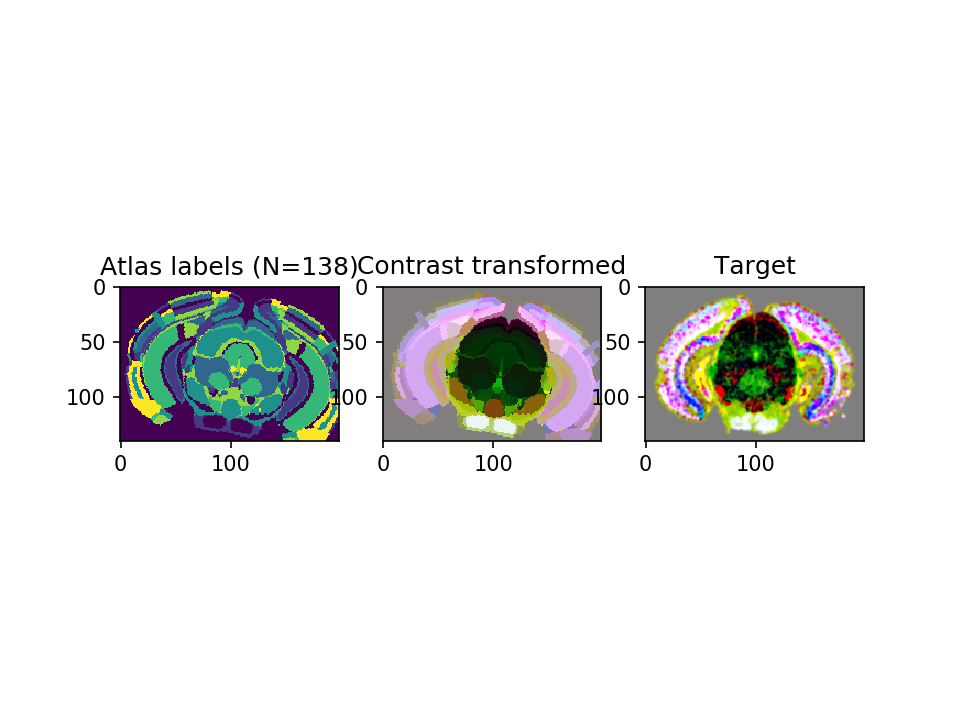

Text(0.5, 1.0, 'Target')

In [14]:
# transform atlas
AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest')# note mode=nearest for labels
# contrast
AI0 = AI - torch.mean(AI)
if it == 0:
    Jbar = torch.mean(J,(-1,-2,-3),keepdims=True)
    J0 = J - Jbar
fAI = AI0 * torch.mean(AI0*J0,(-1,-2,-3),keepdims=True) / torch.mean(AI0**2,(-1,-2,-3),keepdims=True) + Jbar
# we will want to update the contrast based on individual labels
fAI = torch.zeros_like(J)
for l in torch.unique(AI):
    ind = AI==l
    for c in range(npca):
        fAI[c,ind[0]] = torch.mean(J[c,ind[0]])

fig,ax = plt.subplots(1,3)
ax[0].imshow(AI[0][0].detach().cpu()%7)
ax[0].set_title(f'Atlas labels (N={len(torch.unique(AI))})')

ax[1].imshow(norm.cdf(fAI[:3,0].permute(1,2,0).detach().cpu()))
ax[1].set_title('Contrast transformed')

ax[2].imshow(norm.cdf(J[:3,0].permute(1,2,0).detach().cpu()))
ax[2].set_title('Target')

In [15]:
# create a padded 3D J
Jp = torch.cat((torch.zeros_like(J),J,torch.zeros_like(J)),1)
Op = torch.cat((torch.zeros_like(J),J*0+1,torch.zeros_like(J)),1)
# and need a dz
dz = 500.0

xJp = [torch.tensor([-dz,0.0,dz],device=device,dtype=dtype),xJ[1],xJ[2]]

In [16]:
slice_

350

In [17]:
I.shape

torch.Size([1, 264, 160, 228])

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.9848,  0.1736],
        [ 0.0000, -0.1736,  0.9848]], requires_grad=True) tensor([-2150.1243,  4000.0000,  5000.0000], requires_grad=True)


<IPython.core.display.Javascript object>


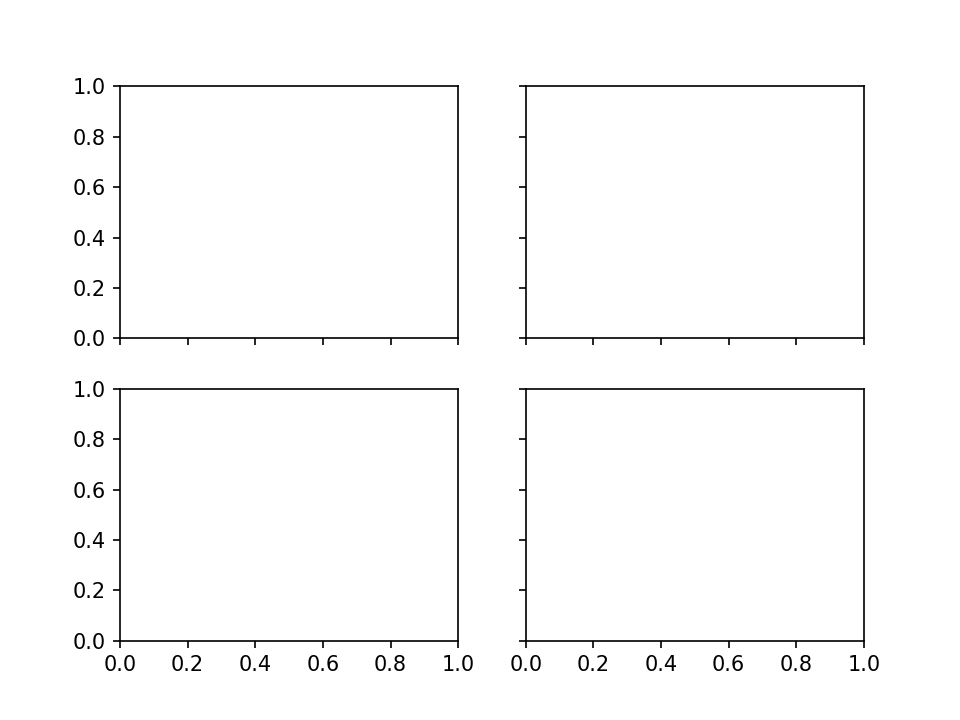

<IPython.core.display.Javascript object>


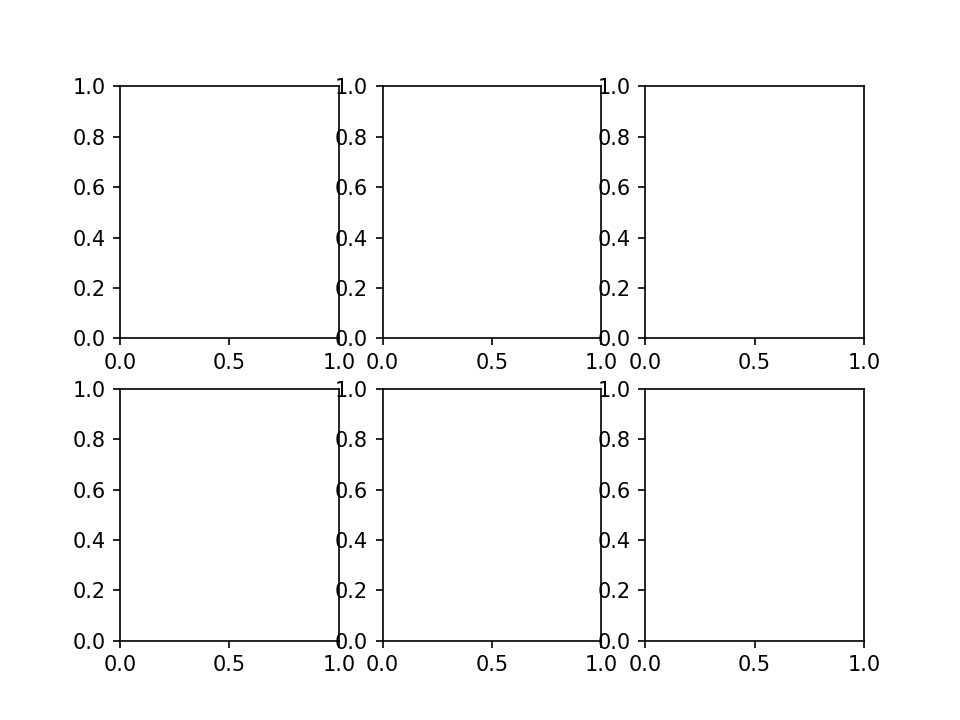

IndexError: The shape of the mask [264, 160, 228] at index 0 does not match the shape of the indexed tensor [1, 264, 160] at index 0

In [19]:
nt = 2
ndraw = 50
v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True,device=device,dtype=dtype)
xv = [torch.as_tensor(x,device=device,dtype=dtype) for x in xv]
XV = torch.as_tensor(XV,device=device,dtype=dtype)
# affine matrix 
L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)
#L.data[1,1] = -1
L.data[1,1] = np.cos(theta0)
L.data[2,1] = np.sin(theta0)
L.data[1,2] = -np.sin(theta0)
L.data[2,2] = np.cos(theta0)
T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
T.data[0] = -xI[0][slice_//2] + dI[0]/2.01 + 2000.0*0 # add offset

T.data[1] = 4000
T.data[2] = 5000
'''
L.data = torch.as_tensor([[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.9604,  0.0349],
         [ 0.0000, -0.0415,  0.8723]],device=device,dtype=dtype)
T.data = torch.as_tensor([-2175.0000,  3867.8140,  4690.3628],device=device,dtype=dtype)
'''
print(L,T)

#f0 is for showing the usual images
f0,ax0 = plt.subplots(2,2,sharex=True,sharey=True)
ax0 = ax0.ravel()
# f1 for showing energy and parameters
f1,ax1 = plt.subplots(2,3)
ax1 = ax1.ravel()

## f2 is for showing my back/forward thing
#f2,ax2 = plt.subplots(2,2)
#ax2 = ax2.ravel()

# optimization
eA = 2e5
ev = 5e8
reduce_3d = 5.0

start3d = 100
startdiff = 10000
niter = 10000

sigmaR = 1e9

Esave = []
ERsave = []
Tsave = []
Lsave = []
maxvsave = []
norm2gradsave = []
for it in range(niter):
    
    # generate
    if ev > 0:
        phii = v_to_phii(xv,v.permute(0,4,1,2,3))    
    else:
        phii = torch.clone(XV).permute(-1,0,1,2)
    
    
    # apply affine transform to atlas
    A = to_A(L,T)
    # invert
    Ai = torch.inverse(A)
    # sample points
    Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

    # 
    Xs = (interp(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)
    #print('calculated transformation')
    
    
    
    # we need to pull the target back for contrast transform
    if not it%5:        
        t0 = time.time()
        with torch.no_grad():
            # transform atlas
            AI = interp(xI,I,Xs.permute(3,0,1,2),mode='nearest') # note mode=nearest for labels
            #ax2[0].cla()
            #ax2[0].imshow(((AI[0,0]%7)/7.0).cpu().numpy(),extent=extent,origin='lower',vmin=0.0,vmax=1.0)
            # this image will only be used for unique labels to speed things up below
            # question? is it good enough? what if there are other labels
            if ev > 0:
                phi = v_to_phii(xv,-torch.flip(v.permute(0,4,1,2,3),(0,)))
            else:
                phi = torch.clone(XV).permute(-1,0,1,2)
            Xs__ = (A[:3,:3]@(phi.permute((1,2,3,0)))[...,None])[...,0] + A[:3,-1]
            # right now we are sampling at the points in v, we need to sample at the points in I
            Xs_ = (interp(xv,Xs__.permute(3,0,1,2),XI.permute(3,0,1,2))).permute(1,2,3,0)
            phiiAiJ = interp(xJp,Jp,Xs_.permute(3,0,1,2))
            phiiAiO = interp(xJp,Op,Xs_.permute(3,0,1,2))
            #print('pulled back')
            # now we do a contrast transform with with weights
            #fI = torch.clone(I) # why am I cloning I?
            # this was a dumb problem, I thought I was just initializing it
            # but some pixels had a giant giant value
            fI = torch.zeros((npca,I.shape[0],I.shape[1],I.shape[2]), device=device,dtype=dtype)
            for l in torch.unique(AI[AI>0]): # only do the indices
                # a lot of these are going to give errors
                ind = I==l
                ep = 1e-3*0
                for c in range(npca):
                    fI[c,ind[0]] = torch.sum(phiiAiJ[c,ind[0]])/(torch.sum(phiiAiO[c,ind[0]]) + ep)
            fI[torch.isnan(fI)] = 0.0
            #fI[fI>torch.max(J)] = 0.0
            # note that when I start shifted by half a slice, the estimation does not look good
        t1 = time.time()
        #print(f'time was {t1-t0}')
        #f2.canvas.draw()
    
    # now we can transform the atlas
    fAI = interp(xI,fI,Xs.permute(3,0,1,2))
    #print('finished transforming atlas')
    
    
  
   
    # cost
    err = fAI-J
    E = torch.mean(err**2)
    #vhat = torch.rfft(v.permute(0,4,1,2,3),3,onesided=False)
    vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))
    #ER = torch.sum(torch.sum(vhat**2,(0,1,-1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
    ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
    E = E + ER
    
    E.backward()

    Esave.append(E.item())
    ERsave.append(ER.item())
    Lsave.append(L.detach().clone().cpu().numpy().ravel())
    Tsave.append(T.detach().clone().cpu().numpy().ravel())
    maxvsave.append(torch.max(v).item())

    # draw
    if not it%ndraw or it == niter-1:
        ax0[0].cla()
        ax0[0].imshow((AI.detach()[0,0].cpu()%7)/7.0,extent=extent,origin='lower',vmin=0.0,vmax=1.0)
        ax0[0].set_title('AI')
        ax0[1].cla()
        ax0[1].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower',vmin=J.min().item(),vmax=J.max().item())
        ax0[1].set_title('fAI')
        ax0[2].cla()
        ax0[2].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
        ax0[2].set_title('J')
        ax0[3].cla()
        ax0[3].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')
        ax0[3].set_title('err')

        ax1[0].cla()
        ax1[0].plot(Esave)
        ax1[0].plot(ERsave)
        ax1[0].set_title('E,ER')
        ax1[1].cla()
        ax1[1].plot(ERsave)
        ax1[1].set_title('ER')
        ax1[2].cla()
        ax1[2].plot(norm2gradsave)
        ax1[2].set_title('|grad|^2')
        ax1[3].cla()
        ax1[3].plot(Lsave)
        ax1[3].set_title('L')
        ax1[4].cla()
        ax1[4].plot(Tsave)
        ax1[4].set_title('T')
        ax1[5].cla()
        ax1[5].plot(maxvsave)
        ax1[5].set_title('max v')

        # it would be good to draw the transform
        levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels.cpu().numpy(),colors='k',linestyles='-')
        
        f0.canvas.draw()
        f1.canvas.draw()

    # update
    with torch.no_grad():
        # combine grads
        grad0 = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
        #print(L,T,grad)
        grad = (gi@grad0).reshape(3,4)
        norm2gradsave.append(torch.sum(grad0.ravel()*grad.ravel()).item())

        if it >= start3d:
            if it == start3d:
                #eL /= 5
                #eT /= 5
                #eA /= 5.0
                eA /= reduce_3d
            #L -= L.grad*eL
            #T -= T.grad*eT
            L -= grad[:3,:3]*eA
            T -= grad[:3,-1]*eA            
            

        else:            
            # this is a 2D update
            
            #L[1:] -= L.grad[1:]*eL
            #T[1:] -= T.grad[1:]*eT
            L[1:,1:] -= grad[1:3,1:3]*eA
            T[1:] -= grad[1:3,-1]*eA
        L.grad.zero_()
        T.grad.zero_()

        if it > startdiff:
            #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1).real
            v -= vgrad*ev
        v.grad.zero_()
        # TODO
        # use metric?
        # identifiability issues?
        

In [ ]:
ind.ape

In [ ]:
# notes
# I am ending up with a significant amount of numerical instability
# the optimization
# I fixed the issue, it had to do with some structures with really bright 
# labels creeping in because I cloned I instead of setting to 0
# I'm not sure why this should have been an issue though
#

In [ ]:
L,T

In [ ]:
eA


In [ ]:
grad.shape,L.shape

In [ ]:
XV.device

In [ ]:
L,T,it>start3d

In [ ]:
grad[1:3,1:3]

In [ ]:
grad[:3,-1]*eA      

In [ ]:
# note dispersion of dentate layer, hippocampal sclerosis in epilepsy
# in dementia cases there was a little dispersion, but not as much as hippocampal sclerosis
# can you see this at the neuroimaging level? hvinters would be surprised
# does AD with epilepsy differ from AD without epilepsy, suggests epileptic variant of AD


In [ ]:
grad

In [ ]:
# todo
# we'll need to look at estimation as a function of slice initialization
# and we'll need to address this issue of some labels not being included in my update (where I was getting bright spots before)

In [ ]:
# note that the optimization moving out of plane is barely barely moving

In [ ]:
# each cell has a unique id, under the column unnamed zero (but they are in the same order on both files)
# columns are genes
# entries are expression
# note, these are actual counts. So they are integers.  
# but the gene expression is generally correlated with the size of the cell 
# (only looking at somas so volume or log volume correction is reasonable)
# the final set of columns, with the word "Blank-XXX"
# this is a way to gauge the background noise.  These are like "false positives"
# we should probably ignore them.  They are mostly zeros.
fname = files[0]
print(fname)
df = pd.read_csv(fname.replace('metadata','by_gene'))
df

In [ ]:
print(fname)
df = pd.read_csv(fname)
df

manju is working on this same dataset, 3 slices and 3 replicates.

previously jean only did one sample.

questions: replicate? not the same tissue section. It comes from a different mouse in approximately the same location.

biological replciate versus technical replictate.

not sure about sex.



How many types are there and how did you do the clustering?

32 clusters. Nearest neighbors analysis gave 10 nearest neighbors, and that gave 32 clusters.

neighbor graph with 10 nearest neighbors.  Then community detection.

May be less clusters.


Slice is about 15 microns.




In [21]:
# issue with atlas ids not being right
I.dtype

torch.float32

In [24]:
np.unique(vol)

array([        0,         1,         2,         6,         7,         9,
              10,        12,        15,        17,        19,        20,
              23,        26,        27,        28,        30,        33,
              35,        36,        38,        41,        42,        50,
              52,        54,        56,        58,        59,        62,
              63,        64,        66,        67,        68,        72,
              74,        75,        78,        81,        83,        84,
              88,        91,        93,        96,        97,        98,
             100,       101,       102,       105,       106,       108,
             113,       114,       115,       117,       118,       120,
             121,       122,       123,       125,       126,       128,
             129,       131,       132,       133,       136,       139,
             140,       143,       145,       146,       147,       148,
             149,       153,       155,       156, 

In [ ]:
vol = 